**Paper**

The Matrix Calculus You need For Deep Learning
- Terence Parr, Jeremy Howard

알아둬야 하는 기초 선형대수, 미적분학 정리

In [1]:
import numpy as np

# 머신러닝, 딥러닝 도구모음
import tensorflow as tf

# 그래프 도구모음
import matplotlib.pyplot as plt

# Shallow Neuron Network (얕은 신경망)

 앞서 공부한 선형회귀는 직선형태로 y = ax + b 형태로 출력되는 것을 알 수 있었다.

그런데, 만약에 많은 변수(무게, 크기, 모양, ...)들을 가지고 선형회귀를 진행하면 좀 더 괜찮지 않을까?

그래서 하나의 선형모양을 우리가 아는 뉴런(neuron)으로 표현을 한다.

 뉴런들을 모아놓은 것들을 계층(layer)이라고 표현을 하고 대체적으로 열벡터(col, 세로)으로 나타낸다.

입력, 은닉, 출력 계층으로 나타낼 수 있다.

입력 = 데이터들을 받는 부분이다. 예시로 무게, 크기, 모양 ... 이것들이 들어간다.

은닉 = 입력에서 받은 x 들을 가공하는 부분이다.

출력 = 은닉에서 가공한것을 답으로 출력한다. 예시로 고양이, 개 등등 답이 들어간다.

## 예시

### 문제

주어진 데이터와 답

데이터 = 좌표평면에 중심을 4개 찍고 그 중심으로 특정한 범위안에 점을 200개씩 찍는다.

답 = 중심들의 답을 1번답, 2번답, 3번답, 4번답으로 표현하고 특정범위안에 점들의 답들이 된다.

1번답 = 200개, 2번답 = 200개, 3번답 = 200개, 4번답 = 200개

### 모델링

입력으로는 평면의 좌표 (x,y) 이므로 두개를 받는다. (2 x 1) 행렬

은닉으로는 임의로 정한다. 128개, (128 x 1) 행렬

출력으로는 답의 개수인 4개로 받는다. (4 x 1) 행렬|

입력은 x , 은닉은 h , 출력은 y로 받고, 기울기 부분은 w, 상수 부분은 b로 받는다.

( w = weight 가중치 , b = bias 편향도 )

입력에서 은닉으로 갈 경우, h = wx + b 로 표현이 된다.

h 는 (128 x 1), x 는 (2 x 1) 행렬이므로

형태를 맞춰주려면 w 는 (128 x 2) 행렬이고 b 는 (128 x 1) 이다.

은닉에서 출력으로 갈 경우, y = wh + b 로 표현이 된다.

y 는 (10 x 1), h 는 (128 x 1) 행렬이므로

형태를 맞춰주려면 w 는 (10 x 128) 행렬이고 b 는 (10 x 1) 이다.

In [2]:
class SNN(tf.keras.Model):
    
    def __init__(self):
        # 상속받기
        # model에서 필요한 함수와 변수들을 가져와줌
        super(SNN, self).__init__()
        
        # layer 만들어주기 d1 = 은닉계층, d2 = 출력계층
        # 또한 activation에 따라서 선형식의 역할이 달라짐 (ex. 회귀, 분류 ...)
        self.d1 = tf.keras.layers.Dense(128, input_dim=2, activation = "sigmoid")
        self.d2 = tf.keras.layers.Dense(4, activation="softmax")
        
    def call(self, x):
        h = self.d1(x)
        y = self.d2(h)
        return y

## Gradient Descent (경사 하강법)

최적화 하는 방법중 하나임.

입력 -> 모델에 넣음 -> 출력 -> 입력과 출력과의 오차

이 오차들을 줄이기 위해 미분을 통해서 모델에 있는 변수들의 값들을 바꿈 (w, h)

다시 입력 -> 모델에 넣음 -> 출력 -> 입력과 출력과의 오차

이것을 계속 반복하여 오차들을 줄여나가면서 모델이 최적화가 됨

필요한 것 = loss(손실함수) , optimizer(최적화 함수도구), metric(평가 도구)

In [3]:
@tf.function

# 넣을 모델, 문제, 정답, 오차, 최적화, 오차와 정확도 계산도구
def train_step(model, inputs, labels, loss_object, optimizer, train_loss, train_accuracy):
    
    # 미분할 변수 저장
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_object(labels, predictions)
        
    # 미분
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # 미분하여 최적화 시키는 변수들 저장
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # 한 세트 훈련 후 오차와 정확도 계산
    train_loss(loss)
    train_accuracy(labels,predictions)

### 모델 정의해주기

In [4]:
# 입력 = 2, 은닉 = 128, 출력 = 10
Model = SNN()

### 문제와 정답 세트 만들기

In [5]:
np.random.seed(22)
point = []
label = []
center = 5*np.random.randn(4,2)

for index, center in enumerate(center) :
    for num in range(100):
        point.append(center + np.random.randn(2))
        label.append(index)

point = np.stack(point, axis=0)
label = np.stack(label, axis=0)

# 또한 훈련세트에 넣을 때는 문제랑 정답 순서를 섞기도 해야하고
# 훈련시킬때 한개한개씩 넣지않고 훈련세트를 한꺼번에 넣는다 (batch)

# 32개씩 넣어 훈련시킴
train_set = tf.data.Dataset.from_tensor_slices((point, label)).shuffle(400).batch(32)

In [6]:
point

array([[  0.16674386,  -7.87826704],
       [ -0.43089448,  -7.54752045],
       [  0.12800262,  -6.56443568],
       [ -1.51825215,  -6.26078085],
       [  0.28800067,  -6.25207668],
       [  1.06037999,  -8.8053562 ],
       [  1.40024029,  -8.91536629],
       [ -1.10582321,  -6.97942826],
       [  0.58697913,  -6.68760992],
       [ -0.0966905 ,  -6.76100357],
       [ -1.54829913,  -7.29305849],
       [  2.03942704,  -9.80678366],
       [ -0.69461199,  -7.41431672],
       [ -1.34627894,  -7.4534665 ],
       [ -0.35777067,  -7.5676828 ],
       [ -0.5385619 ,  -8.40191743],
       [  0.13517885,  -7.95566134],
       [ -1.56758646,  -5.21060751],
       [ -1.02713737,  -7.79670306],
       [ -2.38297945,  -6.91716472],
       [ -1.50793347,  -8.01063197],
       [  0.28558955,  -6.77984327],
       [ -1.19247138,  -6.76103763],
       [ -0.0274603 ,  -7.45255724],
       [ -1.40085569,  -6.8319859 ],
       [ -1.99257105,  -6.91177437],
       [ -0.44692347,  -8.54846882],
 

In [7]:
point.shape, label.shape

((400, 2), (400,))

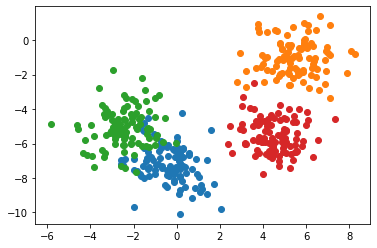

In [8]:
for answer in range(4):
    mask = label == answer
    plt.scatter(point[mask,0], point[mask,1])
    
plt.show()

### 도구들 정의해주기

In [9]:
object_loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

### 훈련시키기

In [10]:
for epoch in range(50):
    
    for train_point, train_label in train_set:
        
        # 훈련시키기
        train_step(Model, train_point, train_label,
                   object_loss, optimizer, train_loss, train_accuracy)
        
    print( "epoch : {}, loss : {}, accuracy : {}".format(epoch + 1,
                                                         train_loss.result(),
                                                         train_accuracy.result() * 100
                                                        ))
          
    train_loss.reset_states()
    train_accuracy.reset_states()

epoch : 1, loss : 1.2954809665679932, accuracy : 34.0
epoch : 2, loss : 1.1305816173553467, accuracy : 63.75
epoch : 3, loss : 1.0194776058197021, accuracy : 91.5
epoch : 4, loss : 0.9243568778038025, accuracy : 94.25
epoch : 5, loss : 0.8478960394859314, accuracy : 95.25
epoch : 6, loss : 0.7802504301071167, accuracy : 92.0
epoch : 7, loss : 0.7255308628082275, accuracy : 93.75
epoch : 8, loss : 0.6769424676895142, accuracy : 93.0
epoch : 9, loss : 0.630744993686676, accuracy : 93.0
epoch : 10, loss : 0.591126561164856, accuracy : 93.5
epoch : 11, loss : 0.5569371581077576, accuracy : 94.0
epoch : 12, loss : 0.5263732671737671, accuracy : 94.75
epoch : 13, loss : 0.5012010931968689, accuracy : 95.25
epoch : 14, loss : 0.4726293683052063, accuracy : 95.25
epoch : 15, loss : 0.4470708668231964, accuracy : 95.0
epoch : 16, loss : 0.43004482984542847, accuracy : 95.0
epoch : 17, loss : 0.40701043605804443, accuracy : 95.5
epoch : 18, loss : 0.3892793655395508, accuracy : 95.0
epoch : 19, 

In [11]:
pred = []
for i in range(400):
    pred.append ( np.argmax(Model(point)[i]) )
pred = np.array(pred)

In [12]:
point.shape, pred.shape

((400, 2), (400,))

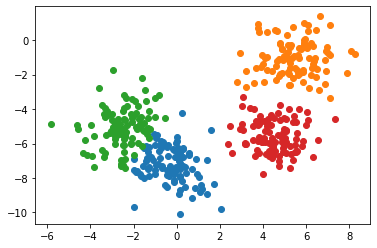

In [13]:
for answer in range(4):
    mask = pred == answer
    plt.scatter(point[mask,0], point[mask,1])
plt.show()

In [14]:
# 맞춘 확률 구하기
num = label == pred
num.sum() / len(num) * 100

95.5

In [15]:
a, b, c, d = Model.weights
a.shape, b.shape, c.shape, d.shape

(TensorShape([2, 128]),
 TensorShape([128]),
 TensorShape([128, 4]),
 TensorShape([4]))

In [16]:
Model.count_params()

900

In [17]:
128 * 2 + 128 + 128 * 10 + 10

1674